In [1]:
import numpy as np
from scipy import signal
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt

import f06_postpro as f06

### Funciones de transferencia nodales por simulación

In [4]:
freq, accel = f06.read_nodes_accel('C:\RUNRUN\sate_corners_sinex.f06')

1
11
12
13
14
15
16
17
18


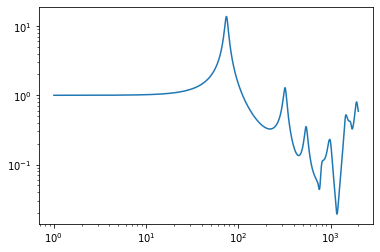

In [31]:
plt.loglog(freq, np.abs(accel['15'][:,0]))

In [6]:
# Transfer matrix
input_node = 1
input_node_str = str(input_node)

TF_dict = accel.copy()
# Delete input node
if input_node_str in TF_dict: del TF_dict[input_node_str]

total_nodes = len(TF_dict.keys())
dof_per_node = 3
total_dofs = total_nodes * dof_per_node
TF = np.zeros((len(freq), total_dofs), dtype=complex)
node_order = dict()
col = 0
for node_str in TF_dict.keys():
    node_order[node_str] = col
    TF[:,col:col+3] = TF_dict[node_str]
    col += 3

### Ruido blanco en la base

In [7]:
g_rms = 1
t_end = 60
delta_t = 1/4000
t = np.linspace(0, t_end, int(t_end/delta_t))
Ug_time = g_rms * np.random.normal(size=len(t))

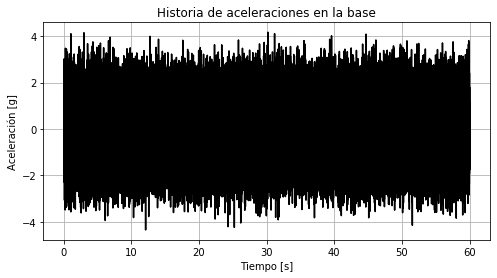

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, Ug_time, color='k', marker='')
plt.title('Historia de aceleraciones en la base')
plt.xlabel('Tiempo [s]')
plt.ylabel('Aceleración [g]')
ax.grid(True, markevery=1)

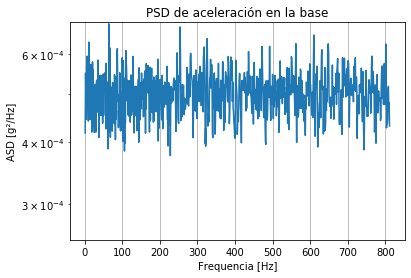

In [9]:
# PSD de aceleraciones en la base
nperseg = 4094
Ug_psd_freq, Ug_psd = signal.welch(Ug_time, 
                      fs=1./(delta_t), # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      detrend='constant', # detrend x by subtracting the mean)
                      return_onesided=True)

plt.figure()
plt.semilogy(freq[1:len(Ug_psd)//2], Ug_psd[1:len(Ug_psd)//2])
plt.title('PSD de aceleración en la base')
plt.ylim([np.min(Ug_psd[1:]), np.max(Ug_psd[1:])])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

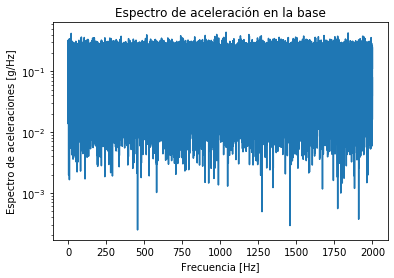

In [10]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft = np.fft.fft(Ug_time) * delta_t
Ug_fft_freq = np.fft.fftfreq(len(t), d=delta_t)

plt.figure()
plt.semilogy(Ug_fft_freq[:len(Ug_fft_freq)//2], abs(Ug_fft[:len(Ug_fft_freq)//2]))
plt.title('Espectro de aceleración en la base')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')
plt.show()

### Respuestas nodales

In [11]:
# Interpolacion de transferencias las frecuencias de excitación
TF_inter = np.zeros((len(Ug_fft_freq), TF.shape[1]), dtype=complex)
for dof in range(TF.shape[1]):
    TF_inter[:,dof] = 2*np.interp(Ug_fft_freq, freq, TF[:,dof])

In [12]:
# Espectros de respuesta
ddotY_fft = (TF_inter.T*Ug_fft).T

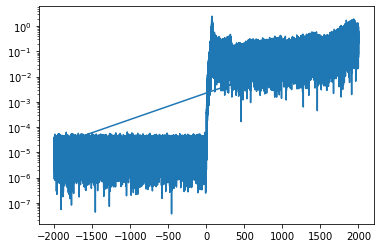

In [20]:
plt.semilogy(Ug_fft_freq, np.abs(ddotY_fft[:,5]))

In [14]:
# Respuestas temporales
ddotY_time = fftpack.ifft(ddotY_fft, axis=0)

### Estimador H1 de la FRF

In [15]:
csd_nperseg = 2048
S_xf = np.zeros((csd_nperseg, total_dofs), dtype=complex)
for dof in range(total_dofs):
        f_S, S_xf[:, dof] = signal.csd(ddotY_time[:, dof], Ug_time,
                                               fs=1./(delta_t),
                                               window='hanning',
                                               nperseg=csd_nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

In [16]:
H1 = S_xf/Ug_psd[:, np.newaxis]

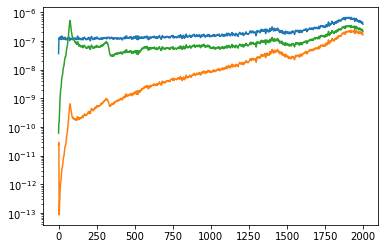

In [17]:
plt.semilogy(f_S[:len(f_S)//2], np.abs(S_xf[:len(f_S)//2,:3]))

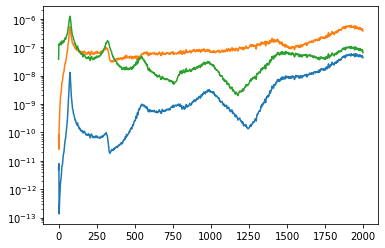

In [18]:
plt.semilogy(f_S[:len(f_S)//2], np.abs(S_xf[:len(f_S)//2,-8:-5]))

### Matriz de densidades espectrales de respuesta

In [21]:
S_xx = np.zeros((csd_nperseg, total_dofs, total_dofs), dtype=complex)
for dof1 in range(total_dofs):
    for dof2 in range(total_dofs):
        f_S, S_xx[:, dof1, dof2] = signal.csd(ddotY_time[:, dof1], ddotY_time[:, dof2],
                                               fs=1./(delta_t),
                                               window='hanning',
                                               nperseg=csd_nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

In [25]:
# Extraigo frecuencias y formas de modo por SVD
u_fdd, s_fdd, vh_fdd = np.linalg.svd(S_xx)

# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s_fdd[:len(f_S)//4, 0], order=30)]).flatten()

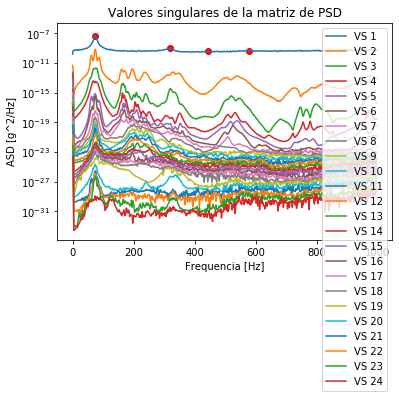

In [26]:
plt.semilogy(f_S[:len(f_S)//4], s_fdd[:len(f_S)//4, :])
# plt.ylim([s[len(f_S)//4, 0], None])
plt.scatter(f_S[mode_ind_fdd[:4]],
            abs(s_fdd[mode_ind_fdd[:4], 0]),
            color='r')
plt.title('Valores singulares de la matriz de PSD')
plt.ylabel('ASD [g^2/Hz]')
plt.xlabel('Frequencia [Hz]')
lgnd  = ['VS {}'.format(col+1) for col in range(s_fdd.shape[1])]
plt.legend(lgnd, loc='upper right')
plt.show()

In [27]:
f_S[mode_ind_fdd[:4]]

array([ 74.21875 , 320.3125  , 445.3125  , 580.078125])

In [30]:
np.abs(u_fdd[mode_ind_fdd[0],:,0])

array([3.39306326e-02, 2.00542759e-04, 1.61803337e-01, 3.38205123e-02,
       1.96845569e-04, 1.62159766e-01, 3.40008587e-02, 2.02321371e-04,
       1.62358554e-01, 3.38896319e-02, 1.98060370e-04, 1.61607173e-01,
       4.43222224e-01, 4.02920466e-03, 1.61973577e-01, 4.42901943e-01,
       4.00573735e-03, 1.62326358e-01, 4.43210528e-01, 4.02919413e-03,
       1.62525059e-01, 4.42908023e-01, 4.00572153e-03, 1.61775990e-01])